## *DISCLAIMER*
<p style="font-size:16px; color:#117d30;">
 By accessing this code, you acknowledge the code is made available for presentation and demonstration purposes only and that the code: (1) is not subject to SOC 1 and SOC 2 compliance audits; (2) is not designed or intended to be a substitute for the professional advice, diagnosis, treatment, or judgment of a certified financial services professional; (3) is not designed, intended or made available as a medical device; and (4) is not designed or intended to be a substitute for professional medical advice, diagnosis, treatment or judgement. Do not use this code to replace, substitute, or provide professional financial advice or judgment, or to replace, substitute or provide medical advice, diagnosis, treatment or judgement. You are solely responsible for ensuring the regulatory, legal, and/or contractual compliance of any use of the code, including obtaining any authorizations or consents, and any solution you choose to build that incorporates this code in whole or in part.
</p>

# Quality Control in Manufacturing - Automatic Defect Detection
<h3><span style="color: #117d30;"> Using Azure Custom Vision Congnitive Services</span></h3>

## Scenario Overview

**Azure Custom Vision** is a cognitive service which helps in building and deploying object detection and image classification models. 

This notebook provides an end-to-end demo on how to use the Azure Cognitive Services Custom Vision API to build and deploy a classification model for **automated sub-assembly inspection for quality control purpose**. 

In this scenario we will see how the model will classify whether a given item is good or defective. If the model classifies the given piece as defective, it will be automatically marked as defective.

### Setting-Up: 

+ Defining the storage, file path and file name for **raw input** images
+ Defining the storage, file path and file name for **processed output** images
+ Downloading the images from an **ADLS Gen2 storage container**

In [1]:
%%capture

## Fixing the asyncio and blob storage package issues
!pip install --use-feature=2020-resolver azure-storage-blob==0.37.1
!pip install nest_asyncio
import nest_asyncio
nest_asyncio.apply()

# importing libraries for ADLS Gen2 connection
import os
from azure.storage.blob import BlockBlobService

# Importing user defined config
import config

# setting up blob storage configs
STORAGE_ACCOUNT_NAME = config.STORAGE_ACCOUNT_NAME
STORAGE_ACCOUNT_ACCESS_KEY = config.STORAGE_ACCOUNT_ACCESS_KEY
STORAGE_CONTAINER_NAME = "qualitycontrol"

# creating blob service object and list blobs inside input_folder
input_folder="input/"
output_folder="output/"
blob_service = BlockBlobService(STORAGE_ACCOUNT_NAME, STORAGE_ACCOUNT_ACCESS_KEY)
generator= blob_service.list_blobs(STORAGE_CONTAINER_NAME, prefix=input_folder)

# initializing several lists that will be used in the following cells
input_list=[]
output_list=[]
blob_file_list=[]
blob_output_list=[]

# creating the input and output folders if they do not exist
if not os.path.isdir("input"):
   os.mkdir("input")
if not os.path.isdir("output"):
   os.mkdir("output")

# getting the names of blob files and appending them to the list
for c in generator:
    blob_file_list.append(c.name)

# downloading the images from ADLS Gen2 storage
for i,blob_file in enumerate(blob_file_list):
     local_path = os.path.join(os.getcwd(), blob_file)
     blob_service.get_blob_to_path(STORAGE_CONTAINER_NAME, blob_file ,local_path)

# creating several lists
for i,image in enumerate(os.listdir("input")):
    full_path=os.path.join(os.getcwd(),"input",image)
    output_path=os.path.join(os.getcwd(),"output",image)
    blob_output="output/" + image
    input_list.append(full_path)
    output_list.append(output_path)
    blob_output_list.append(blob_output)

## Installing OpenCV and importing other python libraries  

OpenCV is one of the most popular computer vision libraries for image and video processing. In this notebook, we will install python binding for  OpenCV. 

We will also import other libraries like  **matplotlib**,  **numpy**, **pandas**, etc. that are required at different stages in this notebook for manipulating and processing images.    

In [2]:
# for converting the frames into bytes
import cv2 

# for processing arrays   
import numpy as np

# for encoding and decoding Custom Vision predictions 
import json

# for converting the Custom Vision predictions to dataframe   
import pandas as pd

# import async packages
import asyncio
import aiohttp

# for displaying images from the processed images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# importing other required libraries
import io
import time
from PIL import ImageFont, ImageDraw, Image

### Displaying raw images before processing


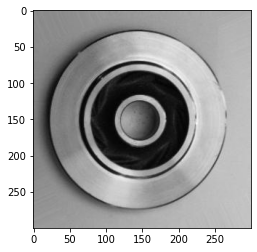

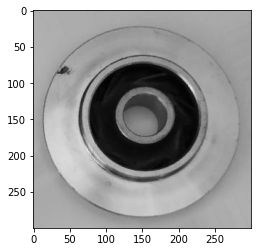

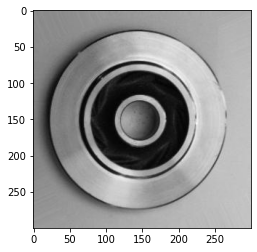

In [3]:
#displaying the raw images before processing
for _,file in enumerate(input_list):
   img = mpimg.imread(file)
   imgplot = plt.imshow(img)
   plt.show()  

## Making API Call to Custom Vision Cognitive Service  

Now we will define connections details for making the API call to the Custom Vision Service 


In [4]:
# web service end-point foe the Custom Vision model    
# we will process images  
POST_URL = config.QUALITY_CONTROL_POST_URL

# providing prediction key
HEADERS = config.QUALITY_CONTROL_HEADERS

# number of API calls per pool of request   
MAX_CONNECTIONS = 100

## Functions to Converting Raw Input Images to Processed Images


### function: getFrames

This function takes a  list of image files as input and returns list of frames    


In [5]:
# returns list of arrays from list of images
def getFrames(input_list):
    images = []
    byteImages = []
    for _,k in enumerate(input_list):
        image = cv2.imread(k)
        images.append(image)
        global HEIGHT, WIDTH
        HEIGHT, WIDTH, lay = images[0].shape
    return images

### function: convertCVImagesToByteImages

This function takes a list of frames as input and returns list of Byte arrays 

In [6]:
# returns list of byte arrays
def convertCVImagesToByteImages(frames):
    toReturnByteImages = []
    for frame in frames:
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        is_success, im_buf_arr = cv2.imencode(".jpg", image)
        if is_success:
            byte_im = im_buf_arr.tobytes()
            toReturnByteImages.append(byte_im)
    return toReturnByteImages

### function:  fetch_all

This function takes a list of byteImages and returns the list of raw responses


In [7]:
# making async requests call
async def fetch(session, url, data,i):
    print("Request #" + str(i) + " Sent")
    async with session.post(url,headers=HEADERS, data=data) as response:
        resp = await response.text()
        print("Request #"+ str(i) + " Complete")
        return resp

# Setting up for batch requests
async def fetch_all(byteImages):
    conn = aiohttp.TCPConnector(limit=len(byteImages)+1)
    async with aiohttp.ClientSession(connector=conn) as session:
        tasks = []
        i = 0
        for image in byteImages:
            i = i+1
            # if i%20 == 0:
                # time.sleep(3)
            tasks.append( fetch(session, POST_URL, image, i) )

        responses = await asyncio.gather(*tasks, return_exceptions=True)
        return responses


### function: getDFfromResponse

This function takes a JSON as input and convert them into dataframe.


In [8]:
# converts JSON to Pandas dataframe 
def getDFfromResponse(response):
    resp = json.loads(response)
    pred_resp= resp['predictions']
    pred_df=pd.DataFrame(pred_resp)
    final_df = pred_df.head(1)
    return final_df

### function: get_label

This function takes predicted label as input and returns the text and color for that label


In [9]:
# returns color and text for given prediction
def get_label(value):
    if value=="def_front":
        fill=(255,0,0,255)
        text="Defective"
    else:
        fill=(0,255,0,255)
        text="Good"
    return text,fill

### function: process_image

This function converts list of raw images into list of processed images. This function relies on several other functions that are defines above. 


In [10]:
# converts list of raw images to processed images
def process_image(input_list,output_list):
    frames = getFrames(input_list)
    byteImages=convertCVImagesToByteImages(frames)
    loop = asyncio.get_event_loop()
    response_list = loop.run_until_complete(fetch_all(byteImages))
    fontPath = "/usr/share/fonts/truetype/dejavu/DejaVuSerif-Bold.ttf"
    sans16  =  ImageFont.truetype ( fontPath, 20 )
    
    for i,response in enumerate(response_list):
        df=getDFfromResponse(response)
        tag_value=(df['tagName'].head(1).values)[0]
        text,fill=get_label(tag_value)
        
        # Convert to PIL Image
        cv2_im_rgb = cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB)
        pil_im = Image.fromarray(cv2_im_rgb)

        draw = ImageDraw.Draw(pil_im)

        # Draw the text
        draw.text((0, 0), text,fill=fill,font=sans16 )

        # Save the image
        cv2_im_pcd = cv2.cvtColor(np.array(pil_im), cv2.COLOR_RGB2BGR)
        cv2.imwrite(output_list[i], cv2_im_pcd)

## Image Conversion and ADLSGen2 Storage  

We wil make functions call to convert list of raw images to list of processed images and store them to ADLSGen2 storage. 


In [11]:
# converts list of raw images to list of processed images
process_image(input_list,output_list)

Request #2 Sent
Request #3 Sent
Request #1 Sent
Request #1 Complete
Request #2 Complete
Request #3 Complete


In [12]:
%%capture

# uploads processed images to an ADLS Gen2 Storage container
for i,blob_out in  enumerate(blob_output_list):
    blob_service.create_blob_from_path(
                 STORAGE_CONTAINER_NAME, blob_out, output_list[i])

### Displaying Processed images


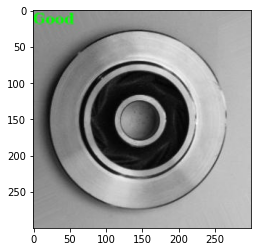

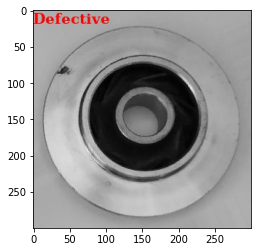

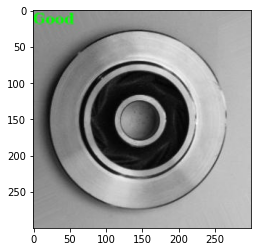

In [13]:
# displays the final processed images
for _,file in enumerate(output_list):
   img = mpimg.imread(file)
   imgplot = plt.imshow(img)
   plt.show()